# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I use has been provided by AZ Direct and Arvato Finance Solution, and represents a real-life data science task.

Their main question of interest is to identify facets of the population that are most likely to be purchasers of their products for a mailout campaign. In this notebook, I use unsupervised learning techniques to organize the general population into clusters, then use those clusters to see which of them comprise the main user base for the company. Prior to applying the machine learning methods, I also needed to assess and clean the data in order to convert the data into a usable form.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I use this information to cluster the general population into groups with similar demographic properties. This shows how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [6]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [7]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [9]:
print(f'The number of persons in the demographics data is {azdias.shape[0]}, and there are {azdias.shape[1]} features.', "\n")

The number of persons in the demographics data is 891221, and there are 85 features. 



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. This file is used to help with cleaning decisions for the data. First of all, I assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I start with a little bit of parsing to make use of it to identify and clean the data. Then I convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [10]:
print(f'There is a total of {azdias.isna().sum().sum()} naturally missing values in the entire dataset.', "\n")


There is a total of 4896838 naturally missing values in the entire dataset. 



In [11]:
# Find out the columns with '0'.
feat_with0 = feat_info.loc[feat_info['missing_or_unknown'].isin(['[-1,0]', '[0]', '[-1,0,9]'])]
feat_with0.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
11,GEBURTSJAHR,person,numeric,[0]


In [12]:
azdias[feat_with0['attribute']].head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,GEBURTSJAHR,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,...,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,GEBAEUDETYP,MIN_GEBAEUDEJAHR,KBA05_BAUMAX,KBA05_GBZ,KKK,REGIOTYP,PLZ8_BAUMAX,ORTSGR_KLS9
0,-1,2,1,2.0,0,-1,15.0,4.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1996,3,21.0,6.0,5.0,3.0,...,9.0,11.0,8.0,1992.0,5.0,1.0,2.0,3.0,1.0,5.0
2,-1,3,2,3.0,1979,3,3.0,1.0,1.0,1.0,...,9.0,10.0,1.0,1992.0,0.0,3.0,2.0,2.0,1.0,5.0
3,2,4,2,2.0,1957,2,0.0,0.0,0.0,0.0,...,9.0,1.0,1.0,1997.0,1.0,4.0,0.0,0.0,1.0,3.0
4,-1,3,1,5.0,1963,3,32.0,10.0,10.0,5.0,...,9.0,3.0,1.0,1992.0,0.0,3.0,3.0,5.0,2.0,6.0


In [13]:
# Here we replace all the 0's with NaN
azdias[feat_with0['attribute']] = azdias[feat_with0['attribute']].replace(to_replace=[0, 0.0], value=np.nan)

In [14]:
# Find out the columns with '9'.
feat_with9 = feat_info.loc[feat_info['missing_or_unknown'].isin(['[-1,0,9]', '[-1,9]'])]
feat_with9.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
24,SEMIO_SOZ,person,ordinal,"[-1,9]"
25,SEMIO_FAM,person,ordinal,"[-1,9]"
26,SEMIO_REL,person,ordinal,"[-1,9]"
27,SEMIO_MAT,person,ordinal,"[-1,9]"


In [15]:
# Here we replace all the 9's with NaN
azdias[feat_with9['attribute']] = azdias[feat_with9['attribute']].replace(to_replace=[9, 9.0], value=np.nan)

In [16]:
# Lastly, we replace all other 'missing' or unknown' value code into numpy NaN value
azdias.replace(to_replace=[-1, 'X', 'XX'], value=np.nan, inplace=True)

In [17]:
print(f'The total number of nan after replacement of missing_or_unknown codes is {azdias.isna().sum().sum()}', "\n")

The total number of nan after replacement of missing_or_unknown codes is 8373929 



#### Step 1.1.2: Assess Missing Data in Each Column

There are a few columns that are outliers in terms of the proportion of values that are missing. I use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I just remove them from the dataframe. 

In [18]:
# Here we perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_column_nan = azdias.isna().mean().sort_values(ascending=False)*100
azdias_column_nan

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

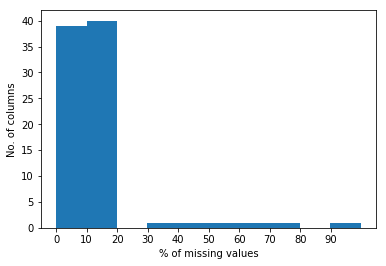

In [19]:
# Histogram of amount of missing data.
plt.hist(azdias_column_nan)
plt.xticks(np.arange(0,100,10), [str(x) for x in np.arange(0,100,10)])
plt.xlabel('% of missing values')
plt.ylabel('No. of columns');

## Comment:

From the histogram, we see that the outliers have more than 20% of missing values. Therefore, we can remove all columns with more than 20% of Nan's.

In [20]:
# Columns that are removed.
removed_columns = azdias_column_nan[azdias_column_nan > 20].index
removed_columns

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [21]:
# Here drop the columns with more than 20% of missing values
azdias.drop(removed_columns, axis=1, inplace=True)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From our observation of the histogram plots, we removed all columns that have more than 20% of missing values. The columns that were removed are, ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'].


#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. As with the columns, we divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We Select a few columns for this comparison.

In [22]:
# How much data is missing in each row of the dataset?
azdias_row_nan = azdias.isnull().sum(axis=1).sort_values(ascending=False)

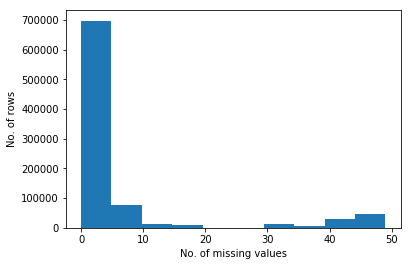

In [23]:
plt.hist(azdias_row_nan)
plt.xlabel('No. of missing values')
plt.ylabel('No. of rows');

In [24]:
# We divide the data into two subsets based on the number of missing values in each row.
threshold = 20
above_threshold = azdias[azdias.isnull().sum(axis=1) >= threshold]
below_threshold = azdias[azdias.isnull().sum(axis=1) < threshold]

In [25]:
len(above_threshold), len(below_threshold)

(94144, 797077)

In [26]:
# We compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Here we select columns of above_threshold subsets with zero missing values
above_threshold_column_nan = above_threshold.isnull().sum(axis=0)
above_threshold_nan_equal0 = above_threshold_column_nan[above_threshold_column_nan == 0].index
above_threshold_nan_equal0

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

In [27]:
# Here we select columns of above_threshold subsets with zero missing values
below_threshold_column_nan = below_threshold.isnull().sum(axis=0)
below_threshold_nan_equal0 = below_threshold_column_nan[below_threshold_column_nan == 0].index
below_threshold_nan_equal0

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'GEBAEUDETYP',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'],
      dtype='object')

In [28]:
# We pick the first six features that are common to both above and below data with zero's Nan
np.random.seed(300)
selected_feature = np.random.choice(list(set(above_threshold_nan_equal0) & set(below_threshold_nan_equal0)), size=(6),  replace=False)
selected_feature

array(['SEMIO_KAEM', 'SEMIO_KULT', 'SEMIO_LUST', 'FINANZ_HAUSBAUER',
       'SEMIO_RAT', 'FINANZ_MINIMALIST'], 
      dtype='<U21')

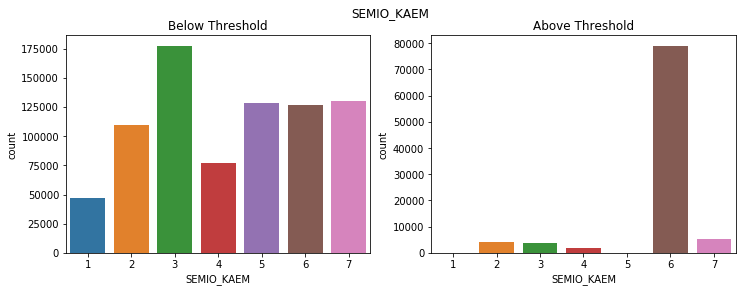

In [29]:
fig = plt.figure(10, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Below Threshold')
sns.countplot(below_threshold[selected_feature[0]])

ax2 = fig.add_subplot(122)
ax2.title.set_text('Above Threshold')
sns.countplot(above_threshold[selected_feature[0]])


fig.suptitle(selected_feature[0]);

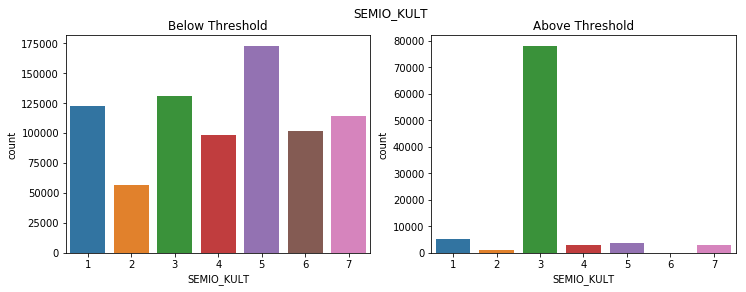

In [30]:
fig = plt.figure(10, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Below Threshold')
sns.countplot(below_threshold[selected_feature[1]])

ax2 = fig.add_subplot(122)
ax2.title.set_text('Above Threshold')
sns.countplot(above_threshold[selected_feature[1]])


fig.suptitle(selected_feature[1]);

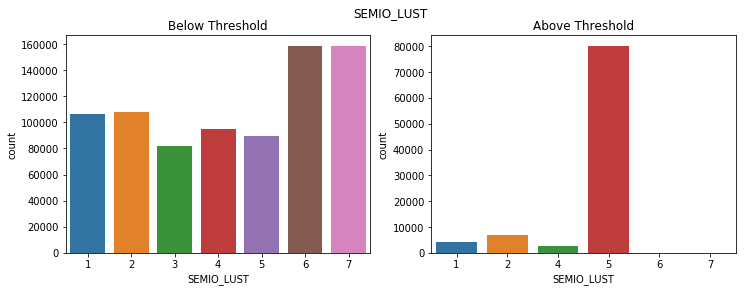

In [31]:
fig = plt.figure(10, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Below Threshold')
sns.countplot(below_threshold[selected_feature[2]])

ax2 = fig.add_subplot(122)
ax2.title.set_text('Above Threshold')
sns.countplot(above_threshold[selected_feature[2]])


fig.suptitle(selected_feature[2]);

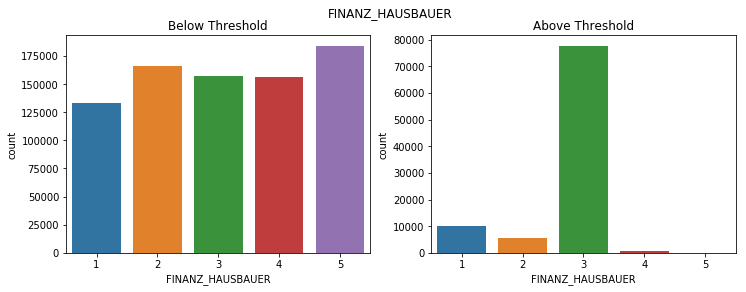

In [32]:
fig = plt.figure(10, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Below Threshold')
sns.countplot(below_threshold[selected_feature[3]])

ax2 = fig.add_subplot(122)
ax2.title.set_text('Above Threshold')
sns.countplot(above_threshold[selected_feature[3]])


fig.suptitle(selected_feature[3]);

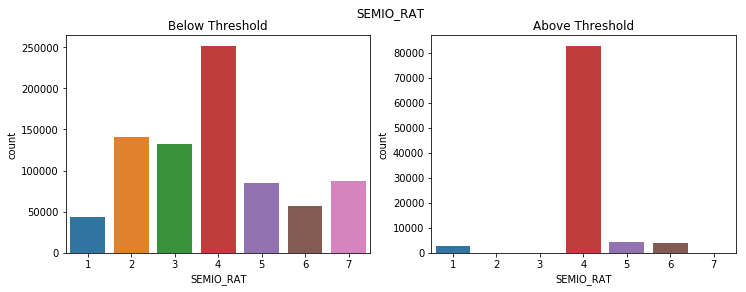

In [33]:
fig = plt.figure(10, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Below Threshold')
sns.countplot(below_threshold[selected_feature[4]])

ax2 = fig.add_subplot(122)
ax2.title.set_text('Above Threshold')
sns.countplot(above_threshold[selected_feature[4]])


fig.suptitle(selected_feature[4]);

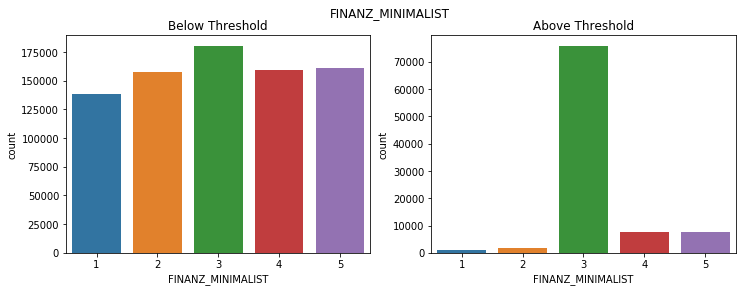

In [34]:
fig = plt.figure(10, figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.title.set_text('Below Threshold')
sns.countplot(below_threshold[selected_feature[5]])

ax2 = fig.add_subplot(122)
ax2.title.set_text('Above Threshold')
sns.countplot(above_threshold[selected_feature[5]])


fig.suptitle(selected_feature[5]);

In [35]:
# Now we drop the data above our threshold
azdias.drop(above_threshold.index, axis=0, inplace=True)

In [36]:
azdias.shape

(797077, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the six plots above, we can observe that the distribution of the data with lots of missing data is qualitatively different from that with few or no missing values. However, we still go ahead and drop these columns.

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we still need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. We make the following assumptions

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.


In [37]:
# We select feat_info dataframe with categorical attributes
df_categorical = feat_info.loc[feat_info['type'].isin(['categorical'])]

In [38]:
# We select feat_info dataframe with categorical attributes
df_mixed = feat_info.loc[feat_info['type'].isin(['mixed'])]

In [39]:
# We select features with categorical data from feat_info
categorical_features = df_categorical['attribute'].tolist()
categorical_features

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. We perform the following operation:
- For binary (two-level) categoricals that take numeric values, we keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we re-encode the values as numbers.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. We document our choice in the next section.

In [40]:
dropped_categorical = []
for label in categorical_features:
    try:
        if len(azdias[label].dropna().unique()) > 2:
            dropped_categorical.append(label)               
    except KeyError:
        pass

In [41]:
dropped_categorical

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [42]:
azdias.drop(dropped_categorical, axis=1, inplace=True)

In [43]:
# We re-encode the binary variable that takes on non-numeric values.
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 21 categorical features in our data set. Amongst these, there are 13 categorical features that are not binary. For these features, I decided to drop them. They are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'].

The rationale for dropping them is that some of them have lots of levels, and doing one-hot encoding will further increase the number of features, which is not desirable. I keep the binary categorical variable and recoded the only one non-numeric binary variable we have (OST_WEST_KZ).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; 

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

###  PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [44]:
# We Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
          8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80,
          14: 90, 15: 90, np.nan: np.nan}
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade)

movement = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0,
            7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1,
            13: 0, 14: 1, 15: 0, np.nan: np.nan}
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement)


### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables
wealth = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1,
         '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
         '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,
         '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
         '51': 5, '52': 5, '53': 5, '54': 5, '55': 5, np.nan: np.nan}

azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].map(wealth)


lifestage = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5,
             '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
             '31': 1, '32': 2, '33': 3, '34': 4, '35': 5,
             '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
             '51': 1, '52': 2, '53': 3, '54': 4, '55': 5, np.nan: np.nan}

azdias['LIFESTAGE'] = azdias['CAMEO_INTL_2015'].map(lifestage)


In [46]:
azdias.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1, inplace=True)

In [47]:
# We select features with mixed data from feat_info
mixed_features = df_mixed['attribute'].tolist()
mixed_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [48]:
for label in mixed_features:
    try:
        print(azdias[label].value_counts(), '\n')
    except KeyError:
        pass

1.0     58718
5.0     52399
6.0     43324
2.0     37146
8.0     28831
11.0    25356
7.0     24947
29.0    24879
13.0    24810
10.0    24458
31.0    22260
12.0    22214
30.0    21145
15.0    18963
3.0     18752
19.0    18575
37.0    17500
4.0     16477
14.0    16350
20.0    16285
32.0    15761
39.0    15131
40.0    14108
27.0    13795
16.0    13632
38.0    13088
35.0    13011
34.0    12421
9.0     12109
21.0    11965
28.0    11543
24.0    11308
25.0     9843
36.0     9654
23.0     8624
22.0     6830
18.0     6802
33.0     5722
17.0     5486
26.0     3368
Name: LP_LEBENSPHASE_FEIN, dtype: int64 

2.0     149501
1.0     131093
3.0     109528
12.0     69481
4.0      51172
5.0      47148
9.0      46024
10.0     38021
11.0     31154
8.0      28706
6.0      27419
7.0      21151
Name: LP_LEBENSPHASE_GROB, dtype: int64 

3.0    249537
7.0    169238
4.0    135867
2.0    100303
5.0     74274
1.0     43876
8.0     17356
0.0      6626
Name: WOHNLAGE, dtype: int64 

1.0    499540
5.0     97333
2.0  

In [49]:
dropped_mixed = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE']
azdias.drop(dropped_mixed, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We have 7 mixed feature in pour data frame: 

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']
 
We re-code the two features 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' into two new variables each, and then dropped the original columns from the dataframe. 'CAMEO_INTL_2015' was recoded into 'LIFESTAGE' AND 'WEALTH' features, while 'PRAEGENDE_JUGENDJAHRE' was split into 'DECADE' and 'MOVEMENT'.

We decide to drop the following features:

* 'LP_LEBENSPHASE_FEIN': this has 40 levels, and doing one-hot encoding will populate the number of features.
* 'LP_LEBENSPHASE_GROB': this could have been re-enginneered based on income and earning level. However, we have a category named just 'single parent', with no other information about their income level, earning level, thereby making re-encoding difficult. For these reason, I decide to drop this feature.
* 'WOHNLAGE' this is another feature that could have stayed, but we have a catgory '0' described as 'no score calculated'. I do not know what level to place it. Is it higher than 'very good neighborhood' or lower than 'new building in rural neighborhood'. This ambiguity made me decide to also drop it.


We decide to keep 'KBA05_BAUMAX' and 'PLZ8_BAUMAX' as these features are well encoded and scaled.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, we write a function to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [102]:
def clean_data(df, df_feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    # Find out the columns with '0'.
    attribute_0 = df_feat.loc[df_feat['missing_or_unknown'].isin(['[-1,0]', '[0]', '[-1,0,9]'])]
    
    # Here we replace all the 0's with NaN
    df[attribute_0['attribute']] = df[attribute_0['attribute']].replace(to_replace=[0, 0.0], value=np.nan)
    
    # Find out the columns with '9'.
    attribute_9 = df_feat.loc[df_feat['missing_or_unknown'].isin(['[-1,0,9]', '[-1,9]'])]
    
    # Here we replace all the 9's with NaN
    df[attribute_9['attribute']] = df[attribute_9['attribute']].replace(to_replace=[9, 9.0], value=np.nan)
    
    # Here we replace -1, X and XX in the whole data set
    df.replace(to_replace=[-1, 'X', 'XX'], value=np.nan, inplace=True)
    
    # We remove columns that were removed in the general population dataset
    df.drop(removed_columns, axis=1, inplace=True)
    
    # Now we drop the data above our threshold
    threshold = 20
    above_threshold = azdias[azdias.isnull().sum(axis=1) >= threshold]
    df.drop(above_threshold.index, axis=0, inplace=True)
    
    # We drop the categorical features that have non-binary categories.   
    df.drop(dropped_categorical, axis=1, inplace=True)
    
    # We recode the non-numeric binary categorical variable.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

    # We investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
    
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables
    df['WEALTH'] = df['CAMEO_INTL_2015'].map(wealth)
    df['LIFESTAGE'] = df['CAMEO_INTL_2015'].map(lifestage)
    
    # We drop the original columns of 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' from df.
    df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # We also here drop the folllowing mixed features
    dropped_mixed = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE']
    df.drop(dropped_mixed, axis=1, inplace=True)
    
    return df    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, we make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. 
- For the actual scaling function, we use [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), scaling each feature to mean 0 and standard deviation 1.

In [51]:
# We check for how many Nan we now have in our dataframe.
print(f'There is a total of {azdias.isna().sum().sum()} naturally missing values in the entire dataset.', "\n")


There is a total of 768378 naturally missing values in the entire dataset. 



In [52]:
imputer = Imputer(missing_values = np.nan,
                        strategy ='mean')
numpy_values = imputer.fit_transform(azdias)
azdias = pd.DataFrame(numpy_values, columns=azdias.columns)

In [53]:
print(f'There is a total of {azdias.isna().sum().sum()} missing values in the entire dataset.', "\n")

There is a total of 0 missing values in the entire dataset. 



In [54]:
# We apply feature scaling to the general population data set.
scaler = StandardScaler()
X = scaler.fit_transform(azdias)
azdias = pd.DataFrame(X, columns=azdias.columns)

### Discussion 2.1: Apply Feature Scaling

We have replaced the Nan values with the mean across each column using the imputer instance. With this step, we show that there are no more missing values in our dataframe.

We also use StandardScaler instance to scale each feature to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- We use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 
- We check out the ratio of variance explained by each principal component as well as the cumulative variance explained by plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on the plot, we select a value for the number of transformed features we'll retain for the clustering part of the project.

In [55]:
# Apply PCA to the scaled data.
n_components = azdias.shape[1]//2
pca = PCA(n_components)
X_pca = pca.fit_transform(azdias)

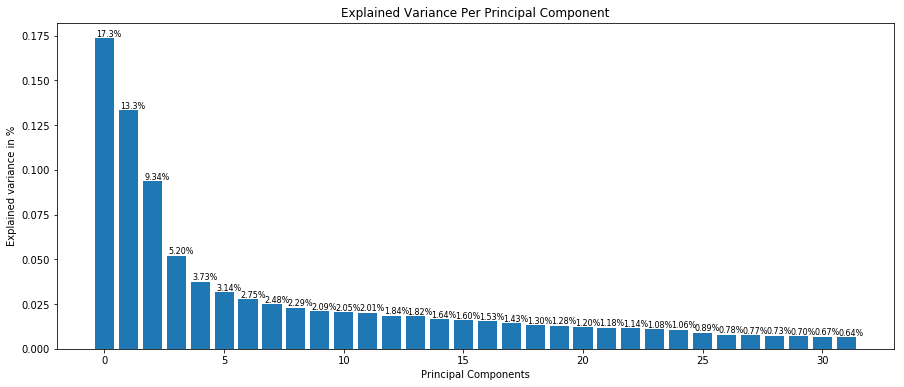

In [56]:
# Investigate the variance accounted for by each principal component.
components = np.arange(n_components)
variance = pca.explained_variance_ratio_
ax = plt.figure(figsize=(15, 6))
plt.bar(components, variance)
plt.xlabel("Principal Components")
plt.ylabel('Explained variance in %')
plt.title('Explained Variance Per Principal Component')
for i in range(len(variance)):
        plt.annotate(r"%s%%" % ((str(variance[i]*100)[:4])), (components[i]+0.2, variance[i]), va="bottom", ha="center", fontsize=8)

Text(0.5,1,'Cumulative Explained Variance Per Principal Component')

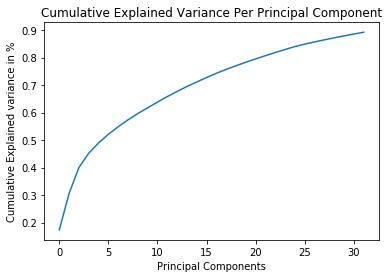

In [57]:
# Investigate the variance accounted for by each principal component.
cum_vals = np.cumsum(variance)
plt.plot(components, cum_vals)
plt.xlabel("Principal Components")
plt.ylabel('Cumulative Explained variance in %')
plt.title('Cumulative Explained Variance Per Principal Component')

In [58]:
print('The least number of components with greater than 80% explained variance is:', np.argwhere(cum_vals > 0.8)[0] + 1)

The least number of components with greater than 80% explained variance is: [22]


In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(22)
X_pca = pca.fit_transform(X)


In [60]:
weights = pca.components_

### Discussion 2.2: Perform Dimensionality Reduction

We perform dimensionality reduction on our scaled data. The findings show that to explain at least 80% of cumulative variance in the original data set, we need to just have 22 components. Therefore, we retain just 22 components out of the original 65 components. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. 

- To investigate the features, we map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 
- We investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. 

In [62]:
# We map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def sort_components(weights, df):
    columns = df.columns
    dict1 = {column: weight for column, weight in zip(columns, weights)}
    sorted_dict =  {column: weight for column, weight in sorted(dict1.items(), key=lambda item: item[1])}
    return sorted_dict
    
    
sorted_dict1 = sort_components(weights[0,:], azdias)
print('The features for the first principal component sorted by weight is: \n\n', list(sorted_dict1.keys()))

The features for the first principal component sorted by weight is: 

 ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA05_ANTG1', 'KBA05_GBZ', 'FINANZ_MINIMALIST', 'PLZ8_GBZ', 'KONSUMNAEHE', 'INNENSTADT', 'BALLRAUM', 'LIFESTAGE', 'GEBAEUDETYP_RASTER', 'GREEN_AVANTGARDE', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'KBA13_ANZAHL_PKW', 'ANZ_PERSONEN', 'SEMIO_ERL', 'SEMIO_LUST', 'ONLINE_AFFINITAET', 'WOHNDAUER_2008', 'MIN_GEBAEUDEJAHR', 'SEMIO_VERT', 'RETOURTYP_BK_S', 'ANZ_TITEL', 'SOHO_KZ', 'KBA05_ANTG2', 'SEMIO_KRIT', 'ANREDE_KZ', 'SEMIO_DOM', 'HEALTH_TYP', 'VERS_TYP', 'ANZ_HH_TITEL', 'SEMIO_SOZ', 'PLZ8_HHZ', 'KKK', 'SEMIO_KAEM', 'W_KEIT_KIND_HH', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'OST_WEST_KZ', 'SEMIO_KULT', 'SEMIO_MAT', 'SEMIO_FAM', 'SEMIO_TRADV', 'REGIOTYP', 'SEMIO_RAT', 'DECADE', 'SEMIO_REL', 'SEMIO_PFLICHT', 'MOVEMENT', 'FINANZ_SPARER', 'KBA05_ANTG3', 'RELAT_AB', 'ANZ_HAUSHALTE_AKTIV', 'ARBEIT', 'KBA05_ANTG4', 'PLZ8_ANTG2', 'FINANZ_HAUSBAUER', 'EWDICHTE', 'HH_EINKOMMEN_SCORE', 'ORTSGR_KL

In [63]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sorted_dict2 = sort_components(weights[1,:], azdias)
print('The features for the second principal component sorted by weight is: \n\n', list(sorted_dict2.keys()))


The features for the second principal component sorted by weight is: 

 ['SEMIO_REL', 'DECADE', 'FINANZ_SPARER', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_KULT', 'FINANZ_ANLEGER', 'SEMIO_FAM', 'SEMIO_RAT', 'SEMIO_MAT', 'ONLINE_AFFINITAET', 'SEMIO_SOZ', 'PLZ8_ANTG1', 'KBA05_GBZ', 'MOBI_REGIO', 'SEMIO_VERT', 'HEALTH_TYP', 'INNENSTADT', 'PLZ8_GBZ', 'KBA05_ANTG1', 'KONSUMNAEHE', 'ANZ_PERSONEN', 'BALLRAUM', 'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP_RASTER', 'KBA13_ANZAHL_PKW', 'KBA05_ANTG2', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'KKK', 'MOVEMENT', 'ANZ_TITEL', 'PLZ8_HHZ', 'LIFESTAGE', 'REGIOTYP', 'OST_WEST_KZ', 'ANZ_HH_TITEL', 'KBA05_ANTG3', 'VERS_TYP', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG2', 'ANZ_HAUSHALTE_AKTIV', 'RELAT_AB', 'ARBEIT', 'KBA05_ANTG4', 'WEALTH', 'WOHNDAUER_2008', 'PLZ8_BAUMAX', 'SEMIO_DOM', 'PLZ8_ANTG4', 'ORTSGR_KLS9', 'PLZ8_ANTG3', 'EWDICHTE', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_HAUSBAUER', 'SEMIO_KAEM', 'SEMIO_KRIT', 'W_KEIT_KIND_HH', 'RETOURTYP_BK_S', 'SEMIO_LUST'

In [64]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sorted_dict3 = sort_components(weights[2,:], azdias)
print('The features for the third principal component sorted by weight is: \n\n', list(sorted_dict3.keys()))

The features for the third principal component sorted by weight is: 

 ['ANREDE_KZ', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_RAT', 'FINANZ_ANLEGER', 'SEMIO_ERL', 'DECADE', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ONLINE_AFFINITAET', 'MOVEMENT', 'FINANZ_HAUSBAUER', 'PLZ8_ANTG1', 'INNENSTADT', 'PLZ8_GBZ', 'KONSUMNAEHE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'HH_EINKOMMEN_SCORE', 'HEALTH_TYP', 'MOBI_REGIO', 'KBA13_ANZAHL_PKW', 'KBA05_GBZ', 'KBA05_ANTG1', 'MIN_GEBAEUDEJAHR', 'KKK', 'KBA05_ANTG2', 'REGIOTYP', 'LIFESTAGE', 'ANZ_PERSONEN', 'SOHO_KZ', 'PLZ8_HHZ', 'KBA05_ANTG3', 'ANZ_TITEL', 'VERS_TYP', 'ANZ_HH_TITEL', 'OST_WEST_KZ', 'WEALTH', 'ANZ_HAUSHALTE_AKTIV', 'KBA05_ANTG4', 'PLZ8_ANTG2', 'RELAT_AB', 'ARBEIT', 'WOHNDAUER_2008', 'PLZ8_ANTG3', 'EWDICHTE', 'PLZ8_ANTG4', 'ORTSGR_KLS9', 'PLZ8_BAUMAX', 'GREEN_AVANTGARDE', 'SEMIO_MAT', 'SEMIO_LUST', 'SEMIO_REL', 'ALTERSKATEGORIE_GROB', 'W_KEIT_KIND_HH', 'FINANZ_VORSORGER', 'RETOURTYP_BK_S', 'FINANZ_MINIMALIS

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts to see how the average distance decreases with an increasing number of clusters. We use this fact to select a final number of clusters in which to group the data. 

In [65]:
# Run k-means clustering over a different number of cluster counts and compute average within-cluster distances.

scores = []
n = 28
for centroid in range(1,n,2):
    kmeans = KMeans(centroid)
    model = kmeans.fit(X_pca)
    scores.append(abs(model.score(X_pca)))
    

    

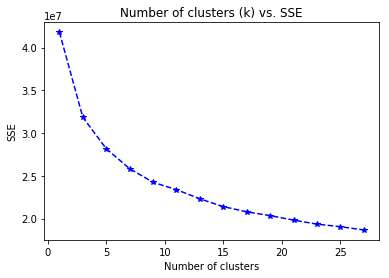

In [67]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

centroids = list(range(1,n,2))
plt.plot(centroids, scores, '--b*')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Number of clusters (k) vs. SSE')
plt.show()

In [111]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(15)
model = kmeans.fit(X_pca)
general_labels = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

We investigate the within-cluster distance across different number of clusters from 1 to 28 with step size of 2, and plotted the scores. From the figure, we decide to cluster our data into 15 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- We apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. 
- We use the sklearn objects from the general demographics data, and apply their transformations to the customers data.

In [118]:
# Load in the customer demographics data.
customer_df = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep=';')

In [120]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
processed_customers = clean_data(customer_df, feat_info)

In [122]:
numpy_values = imputer.transform(processed_customers)
processed_customers = pd.DataFrame(numpy_values, columns=processed_customers.columns)

In [123]:
print(f'There is a total of {processed_customers.isna().sum().sum()} missing values in the customer dataset.', "\n")

There is a total of 0 missing values in the customer dataset. 



In [124]:
customer_scaled = scaler.transform(processed_customers)
customer_pca = pca.transform(customer_scaled)

In [125]:
customer_labels = model.predict(customer_pca)

In [126]:
processed_customers.shape

(191652, 65)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

We consider the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. We use Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) visualizations both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. 
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? We select one such cluster and infer what kind of people might be represented by that cluster. We also use the principal component interpretations from step 2.3 to help you make this inference. Alternatively, we can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Lastly we perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

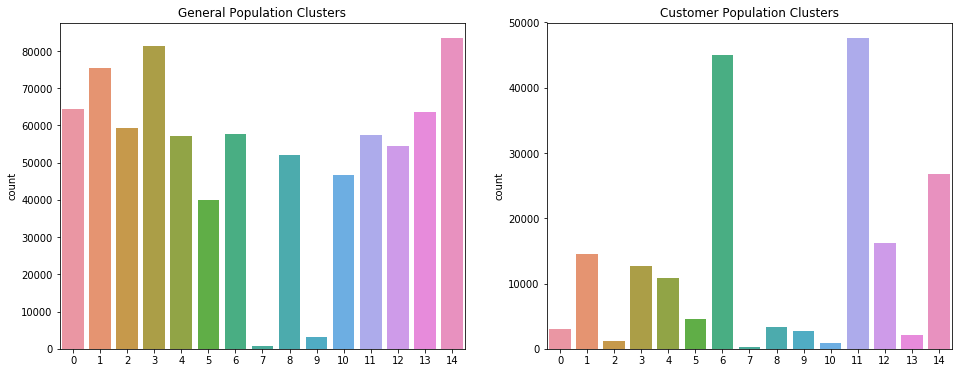

In [127]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))

sns.countplot(general_labels, ax=ax1)
ax1.set_title('General Population Clusters')
sns.countplot(customer_labels, ax=ax2)
ax2.set_title('Customer Population Clusters');


In [128]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_11 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[11]))

In [129]:
overrepresented = pd.Series(data = centroid_11, index=processed_customers.columns)
overrepresented

ALTERSKATEGORIE_GROB        1.692459
ANREDE_KZ                   1.992797
FINANZ_MINIMALIST           1.385077
FINANZ_SPARER               4.225727
FINANZ_VORSORGER            2.329024
FINANZ_ANLEGER              4.337816
FINANZ_UNAUFFAELLIGER       3.865982
FINANZ_HAUSBAUER            3.943247
GREEN_AVANTGARDE            0.059611
HEALTH_TYP                  2.194896
RETOURTYP_BK_S              2.574388
SEMIO_SOZ                   3.140108
SEMIO_FAM                   3.914725
SEMIO_REL                   5.342221
SEMIO_MAT                   5.000685
SEMIO_VERT                  2.342469
SEMIO_LUST                  2.997056
SEMIO_ERL                   4.274205
SEMIO_KULT                  4.040796
SEMIO_RAT                   6.092054
SEMIO_KRIT                  5.484409
SEMIO_DOM                   5.964994
SEMIO_KAEM                  5.767715
SEMIO_PFLICHT               6.146321
SEMIO_TRADV                 5.572280
SOHO_KZ                     0.008072
VERS_TYP                    1.460812
A

In [142]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_0 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[0]))

In [143]:
underrepresented = pd.Series(data = centroid_0, index=processed_customers.columns)
underrepresented

ALTERSKATEGORIE_GROB        1.867968
ANREDE_KZ                   0.950811
FINANZ_MINIMALIST           3.038416
FINANZ_SPARER               4.089818
FINANZ_VORSORGER            2.165580
FINANZ_ANLEGER              3.838738
FINANZ_UNAUFFAELLIGER       4.031991
FINANZ_HAUSBAUER            2.245706
GREEN_AVANTGARDE            0.295000
HEALTH_TYP                  2.185973
RETOURTYP_BK_S              2.491283
SEMIO_SOZ                   6.014336
SEMIO_FAM                   6.553049
SEMIO_REL                   6.328549
SEMIO_MAT                   5.323617
SEMIO_VERT                  6.334548
SEMIO_LUST                  3.173132
SEMIO_ERL                   2.187198
SEMIO_KULT                  6.837453
SEMIO_RAT                   4.240960
SEMIO_KRIT                  2.561534
SEMIO_DOM                   2.577972
SEMIO_KAEM                  1.942424
SEMIO_PFLICHT               5.590232
SEMIO_TRADV                 5.088384
SOHO_KZ                     0.010146
VERS_TYP                    1.431610
A

### Discussion 3.3: Compare Customer Data to Demographics Data

From the analysis, we see that the strongest customer base for the company is in cluster 9, as they are over-represented in the customers data in comparison to the general population data. Segments of the population that are relatively popular with the mail-order company are:

    - People whose estimated age is between 30 - 45 years (ALTERSKATEGORIE_GROB = 1.692459)
    - Females (ANREDE_KZ = 1.992797)
    - People with very high financial topology (FINANZ_MINIMALIST = 1.385077)

However, cluster 8 is underrepresented in the customers data in comparison to the general population data. Segments of the population that are relatively unpopular with the mail-order company are: 

    - People whose estimated age is between 30 - 45 years (ALTERSKATEGORIE_GROB = 1.867968)
    - Males (ANREDE_KZ = 0.950811)
    - People with average financial topology (FINANZ_MINIMALIST = 3.038416)
